In [1]:
# Import necessary libraries for geospatial analysis
import geopandas as gpd

In [2]:
# Load the wards shapefile
wards = gpd.read_file('ikeja_popdensityprojected.shp')

In [29]:
# Load healthcare facilities and AOI boundary shapefiles
healthcare_points = gpd.read_file('healthcare_clip.shp')
aoi_boundary = gpd.read_file('ikeja_dissolve.shp')

In [33]:
from shapely.ops import unary_union

# Create a unified boundary for the entire area of interest
aoi_boundary = unary_union(wards.geometry)

In [5]:
# Import necessary libraries for spatial indexing and geometry
import h3
from shapely.geometry import Polygon

# Define resolution level for hexagon grid (higher value = finer grid)
hex_resolution = 9  # Adjust as needed

# Generate hex IDs within AOI boundary using H3
hex_ids = h3.polyfill(aoi_boundary.__geo_interface__, hex_resolution, geo_json_conformant=True)

# Convert hex IDs to polygons and create a GeoDataFrame
hexagons = [Polygon(h3.h3_to_geo_boundary(h, geo_json=True)) for h in hex_ids]
hex_grid = gpd.GeoDataFrame(geometry=hexagons, crs=wards.crs)

AttributeError: module 'h3' has no attribute 'polyfill'

In [6]:
from h3.api.basic_str import polyfill


ImportError: cannot import name 'polyfill' from 'h3.api.basic_str' (C:\Users\HP\anaconda3\envs\spatialds\lib\site-packages\h3\api\basic_str\__init__.py)

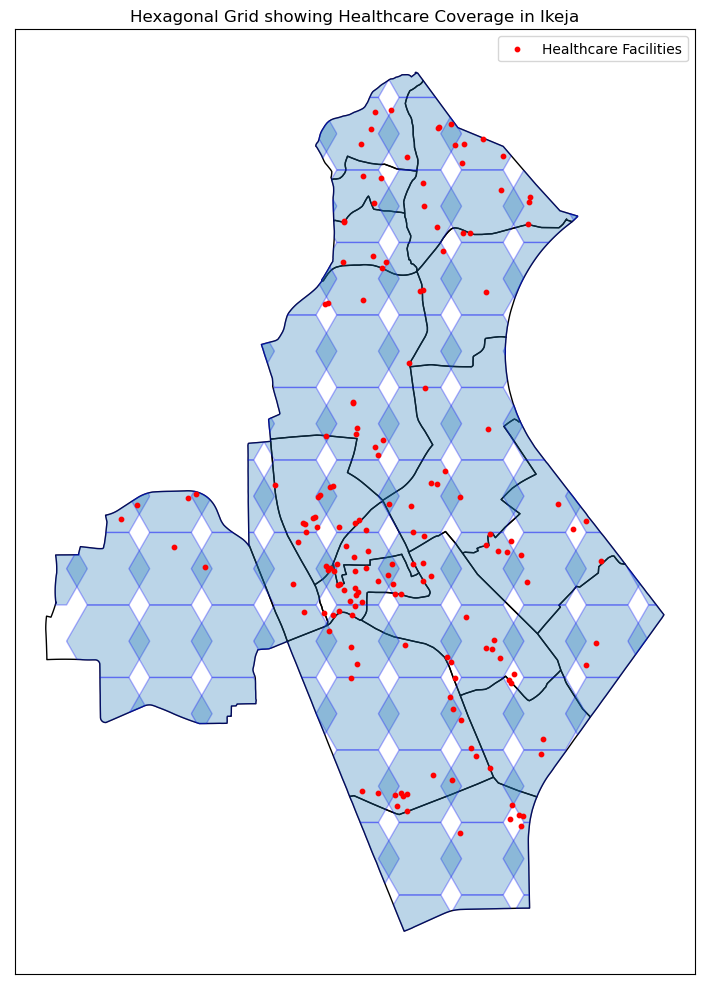

In [72]:
import math
import geopandas as gpd
import matplotlib.pyplot as plt
from shapely.geometry import Polygon

# Get the bounding box of your AOI (unified ward boundaries)
minx, miny, maxx, maxy = aoi_boundary.bounds

# Define hexagon size (adjust based on the scale of your analysis)
hex_size = 0.005  # Modify as needed; this value depends on your CRS and area

# Calculate horizontal and vertical distances for the hexagon layout
dx = 3 / 2 * hex_size
dy = math.sqrt(3) * hex_size

# Initialize an empty list to hold hexagons
hexagons = []

# Create hexagonal grid within the bounding box
x = minx
while x < maxx + dx:
    y = miny
    while y < maxy + dy:
        # Offset every other column to create the hexagonal pattern
        x_offset = x + dx if int((y / dy) % 2) == 0 else x
        hexagon = Polygon([
            (x_offset + math.cos(math.radians(angle)) * hex_size, y + math.sin(math.radians(angle)) * hex_size)
            for angle in range(0, 360, 60)
        ])
        hexagons.append(hexagon)
        y += dy
    x += dx

# Create a GeoDataFrame for the hexagonal grid
hex_grid = gpd.GeoDataFrame(geometry=hexagons, crs=wards.crs)

# Clip hexagons to the AOI boundary
hex_grid = hex_grid[hex_grid.intersects(aoi_boundary)]
hex_grid = gpd.clip(hex_grid, aoi_boundary)  # Clip to match the AOI shape exactly

# Visualize the hexagonal grid over the AOI
ax = wards.plot(edgecolor="black", facecolor="none", figsize=(10, 10))
hex_grid.plot(ax=ax, edgecolor="blue", alpha=0.3)
healthcare_points.plot(ax=ax, color="red", markersize=10, label="Healthcare Facilities")
plt.legend()
plt.title("Hexagonal Grid showing Healthcare Coverage in Ikeja")
# Remove x and y labels
ax.set_xticks([])  # Remove x ticks
ax.set_yticks([])  # Remove y ticks

# Export the visualization as a high-resolution image
plt.tight_layout()
plt.savefig("Healthcare_points_per_grid.png", dpi=300, bbox_inches='tight', facecolor='white')  # Ensure background is white

# Show the plot
plt.show()


In [40]:
# Step 1: Spatial join to overlay population density onto the hexagons

# Intersect the hexagons with population density polygons to get partial overlaps
# Use overlay to split polygons and retain only intersecting areas
hex_population_overlay = gpd.overlay(hex_grid, wards, how='intersection')

# Calculate the area of intersection for each partial polygon
hex_population_overlay['intersection_area'] = hex_population_overlay.area
hex_population_overlay



C:\Users\HP\AppData\Local\Temp\ipykernel_3968\2094489787.py:8: UserWarning: Geometry is in a geographic CRS. Results from 'area' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  hex_population_overlay['intersection_area'] = hex_population_overlay.area


,OBJECTID,WARD,LCDA,LGA,Shape_Leng,Population,P_Density,Shape_Le_1,Shape_Area,geometry,intersection_area
0,6.0,ONIGBONGBO,ONIGBONGBO,IKEJA,7828.698216,18621,0.005800,7828.698171,3.210787e+06,"POLYGON ((3.36687 6.56001, 3.36688 6.55954, 3....",1.766008e-06
1,6.0,ONIGBONGBO,ONIGBONGBO,IKEJA,7828.698216,18621,0.005800,7828.698171,3.210787e+06,"POLYGON ((3.35872 6.56001, 3.35622 6.56434, 3....",6.495191e-05
2,6.0,ONIGBONGBO,ONIGBONGBO,IKEJA,7828.698216,18621,0.005800,7828.698171,3.210787e+06,"POLYGON ((3.36372 6.56434, 3.36622 6.56867, 3....",1.589404e-05
3,6.0,ONIGBONGBO,ONIGBONGBO,IKEJA,7828.698216,18621,0.005800,7828.698171,3.210787e+06,"POLYGON ((3.35872 6.56867, 3.35692 6.57179, 3....",3.149938e-05
4,6.0,ONIGBONGBO,ONIGBONGBO,IKEJA,7828.698216,18621,0.005800,7828.698171,3.210787e+06,"POLYGON ((3.36372 6.57300, 3.36380 6.57314, 3....",8.250642e-06
...,...,...,...,...,...,...,...,...,...,...,...
146,16.0,OKE-IRA POWERLINE,OJODU,IKEJA,5188.283598,14859,0.013508,5188.283702,1.099998e+06,"POLYGON ((3.35336 6.64662, 3.35334 6.64648, 3....",7.837432e-08
147,16.0,OKE-IRA POWERLINE,OJODU,IKEJA,5188.283598,14859,0.013508,5188.283702,1.099998e+06,"POLYGON ((3.35122 6.65095, 3.34910 6.64727, 3....",5.074627e-05
148,16.0,OKE-IRA POWERLINE,OJODU,IKEJA,5188.283598,14859,0.013508,5188.283702,1.099998e+06,"POLYGON ((3.35229 6.64662, 3.35208 6.64664, 3....",2.477384e-05
149,16.0,OKE-IRA POWERLINE,OJODU,IKEJA,5188.283598,14859,0.013508,5188.283702,1.099998e+06,"POLYGON ((3.34768 6.65528, 3.34781 6.65556, 3....",1.488534e-06


In [10]:
hex_population_overlay.columns

Index(['OBJECTID', 'WARD', 'LCDA', 'LGA', 'Shape_Leng', 'Population',
       'P_Density', 'Shape_Le_1', 'Shape_Area', 'geometry',
       'intersection_area'],
      dtype='object')

In [45]:
# Calculate the population density contribution for each intersected area
# Adjust based on intersection area if needed for more accurate estimates
hex_population_overlay['density_contrib'] = hex_population_overlay['Population'] * hex_population_overlay['intersection_area']
hex_population_overlay





,OBJECTID,WARD,LCDA,LGA,Shape_Leng,Population,P_Density,Shape_Le_1,Shape_Area,geometry,intersection_area,density_contrib
0,6.0,ONIGBONGBO,ONIGBONGBO,IKEJA,7828.698216,18621,0.005800,7828.698171,3.210787e+06,"POLYGON ((3.36687 6.56001, 3.36688 6.55954, 3....",1.766008e-06,0.032885
1,6.0,ONIGBONGBO,ONIGBONGBO,IKEJA,7828.698216,18621,0.005800,7828.698171,3.210787e+06,"POLYGON ((3.35872 6.56001, 3.35622 6.56434, 3....",6.495191e-05,1.209469
2,6.0,ONIGBONGBO,ONIGBONGBO,IKEJA,7828.698216,18621,0.005800,7828.698171,3.210787e+06,"POLYGON ((3.36372 6.56434, 3.36622 6.56867, 3....",1.589404e-05,0.295963
3,6.0,ONIGBONGBO,ONIGBONGBO,IKEJA,7828.698216,18621,0.005800,7828.698171,3.210787e+06,"POLYGON ((3.35872 6.56867, 3.35692 6.57179, 3....",3.149938e-05,0.586550
4,6.0,ONIGBONGBO,ONIGBONGBO,IKEJA,7828.698216,18621,0.005800,7828.698171,3.210787e+06,"POLYGON ((3.36372 6.57300, 3.36380 6.57314, 3....",8.250642e-06,0.153635
...,...,...,...,...,...,...,...,...,...,...,...,...
146,16.0,OKE-IRA POWERLINE,OJODU,IKEJA,5188.283598,14859,0.013508,5188.283702,1.099998e+06,"POLYGON ((3.35336 6.64662, 3.35334 6.64648, 3....",7.837432e-08,0.001165
147,16.0,OKE-IRA POWERLINE,OJODU,IKEJA,5188.283598,14859,0.013508,5188.283702,1.099998e+06,"POLYGON ((3.35122 6.65095, 3.34910 6.64727, 3....",5.074627e-05,0.754039
148,16.0,OKE-IRA POWERLINE,OJODU,IKEJA,5188.283598,14859,0.013508,5188.283702,1.099998e+06,"POLYGON ((3.35229 6.64662, 3.35208 6.64664, 3....",2.477384e-05,0.368115
149,16.0,OKE-IRA POWERLINE,OJODU,IKEJA,5188.283598,14859,0.013508,5188.283702,1.099998e+06,"POLYGON ((3.34768 6.65528, 3.34781 6.65556, 3....",1.488534e-06,0.022118


In [46]:
# Group by hexagon and sum up population density contributions to get total density per hexagon
population_density_per_hex = hex_population_overlay.dissolve(by=hex_population_overlay.index, aggfunc='sum')



C:\Users\HP\anaconda3\envs\spatialds\lib\site-packages\geopandas\geodataframe.py:1676: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  aggregated_data = data.groupby(**groupby_kwargs).agg(aggfunc)


In [47]:
# Add density information back to the hex_grid

hex_grid = hex_grid.join(population_density_per_hex[['density_contrib']], how="left", lsuffix="_hex", rsuffix="_pop")


In [48]:

hex_grid['density_contrib'].fillna(0, inplace=True)  # Fill NaNs where there were no overlaps

In [49]:
# Spatial join to count healthcare facilities within each hexagon

# Conduct a spatial join between hexagons and healthcare facilities
# We want to count points in each hexagon, so set op='within'
hex_healthcare_count = gpd.sjoin(hex_grid, healthcare_points, how="left", op="contains")



C:\Users\HP\anaconda3\envs\spatialds\lib\site-packages\IPython\core\interactiveshell.py:3382: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


In [50]:
print(len(hex_healthcare_count))
print(len(hex_grid))


206
79


In [54]:
# Use custom suffixes to avoid conflicts with existing column names
joined = gpd.sjoin(hex_healthcare_count, hex_grid, how="inner", predicate="within", lsuffix='_left', rsuffix='_right')

# Group by index_right and count occurrences to get the healthcare count per hex
healthcare_count_per_hex = joined.groupby('index_right').size()

# Add the healthcare count to hex_grid
hex_grid['healthcare_count'] = healthcare_count_per_hex.reindex(hex_grid.index, fill_value=0)
hex_grid['healthcare_count'].unique()

array([1, 0, 2], dtype=int64)

                                            geometry  density_contrib  \
0  POLYGON ((3.36622 6.56001, 3.36687 6.56001, 3....         0.032534   
1  POLYGON ((3.36372 6.56001, 3.35872 6.56001, 3....         0.008377   
2  POLYGON ((3.36622 6.56001, 3.36372 6.56434, 3....         0.444764   
3  POLYGON ((3.36372 6.56867, 3.35872 6.56867, 3....         1.034036   
4  POLYGON ((3.36622 6.56867, 3.36372 6.57300, 3....         0.023995   

   healthcare_count  
0               1.0  
1               1.0  
2               1.0  
3               1.0  
4               1.0  


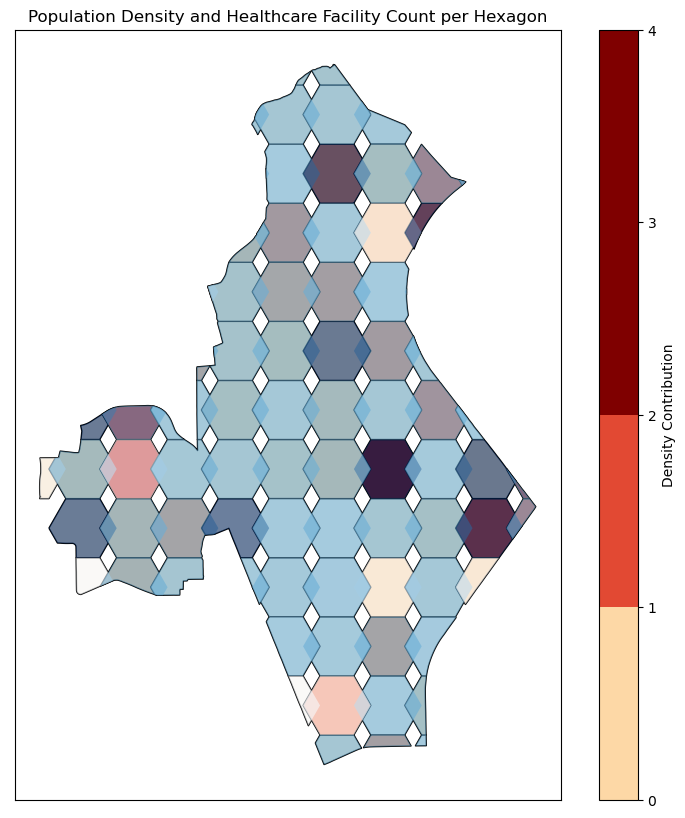

In [57]:
# Add the healthcare count information to hex_grid
hex_grid['healthcare_count'] = healthcare_count_per_hex
hex_grid['healthcare_count'].fillna(0, inplace=True)  # Fill NaNs where no healthcare facilities are present

# Now hex_grid contains both population density and healthcare facility counts per hexagon
print(hex_grid[['geometry', 'density_contrib', 'healthcare_count']].head())

import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

# Define custom boundaries for the legend (4 classes)
boundaries = [0, 1, 2, 3, 4]  # Adjust as per actual data range

# Plot the density_contrib column
ax = hex_grid.plot(
    column="density_contrib",
    cmap="OrRd",
    legend=True,
    edgecolor="black",
    figsize=(10, 10),
    legend_kwds={
        'label': "Density Contribution",
        'orientation': "vertical",
        'boundaries': boundaries,
        'spacing': 'uniform'
    }
)

# Overlay the healthcare_count column with blue markers
hex_grid.plot(
    column="healthcare_count",
    ax=ax,
    cmap="Blues",
    markersize=10,
    alpha=0.6
)

# Set the title
plt.title("Population Density and Healthcare Facility Count per Hexagon")

# Hide x and y axis labels
ax.set_xlabel('')
ax.set_ylabel('')
ax.set_xticks([])
ax.set_yticks([])

plt.show()


                                            geometry  density_contrib  \
0  POLYGON ((3.36622 6.56001, 3.36687 6.56001, 3....         0.032534   
1  POLYGON ((3.36372 6.56001, 3.35872 6.56001, 3....         0.008377   
2  POLYGON ((3.36622 6.56001, 3.36372 6.56434, 3....         0.444764   
3  POLYGON ((3.36372 6.56867, 3.35872 6.56867, 3....         1.034036   
4  POLYGON ((3.36622 6.56867, 3.36372 6.57300, 3....         0.023995   

   healthcare_count  density_to_healthcare_ratio  
0               1.0                     0.032534  
1               1.0                     0.008377  
2               1.0                     0.444764  
3               1.0                     1.034036  
4               1.0                     0.023995  


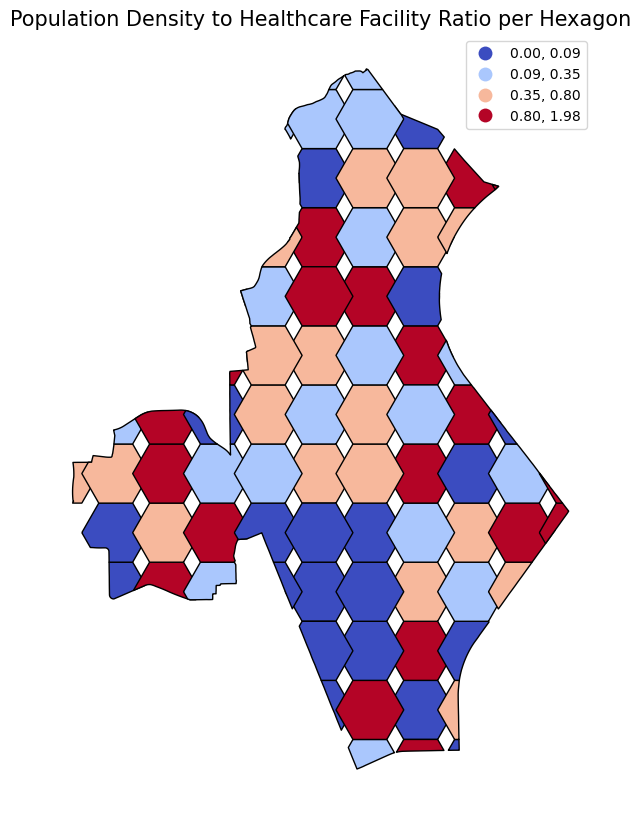

In [59]:
# Step 4: Calculate population density to healthcare facility ratio

# Avoid division by zero by using numpy's `where` to conditionally apply the ratio calculation
import numpy as np

# Calculate the ratio
# If healthcare_count is zero, set the ratio to the density_contrib itself as a high indicator
hex_grid['density_to_healthcare_ratio'] = np.where(
    hex_grid['healthcare_count'] > 0,
    hex_grid['density_contrib'] / hex_grid['healthcare_count'],
    hex_grid['density_contrib']  # Assign density value directly if no healthcare facilities
)

# Display the resulting data
print(hex_grid[['geometry', 'density_contrib', 'healthcare_count', 'density_to_healthcare_ratio']].head())

import matplotlib.pyplot as plt

# Visualize the ratio on a map with custom settings
ax = hex_grid.plot(
    column="density_to_healthcare_ratio",
    cmap="coolwarm",
    legend=True,
    scheme="Quantiles",  # Use quantiles to get 4 classes
    k=4,
    edgecolor="black",
    figsize=(10, 10)
)

# Remove x and y axis labels
ax.set_axis_off()

# Set title
plt.title("Population Density to Healthcare Facility Ratio per Hexagon", fontsize=15)

# Display the plot
plt.show()


In [60]:
hex_grid

,geometry,density_contrib,healthcare_count,density_to_healthcare_ratio
0,"POLYGON ((3.36622 6.56001, 3.36687 6.56001, 3....",0.032534,1.0,0.032534
1,"POLYGON ((3.36372 6.56001, 3.35872 6.56001, 3....",0.008377,1.0,0.008377
2,"POLYGON ((3.36622 6.56001, 3.36372 6.56434, 3....",0.444764,1.0,0.444764
3,"POLYGON ((3.36372 6.56867, 3.35872 6.56867, 3....",1.034036,1.0,1.034036
4,"POLYGON ((3.36622 6.56867, 3.36372 6.57300, 3....",0.023995,1.0,0.023995
...,...,...,...,...
74,"POLYGON ((3.36372 6.63796, 3.35872 6.63796, 3....",0.519811,1.0,0.519811
75,"POLYGON ((3.34872 6.65528, 3.35122 6.65095, 3....",0.204432,1.0,0.204432
76,"POLYGON ((3.35872 6.65095, 3.35622 6.64662, 3....",0.204831,1.0,0.204831
77,"POLYGON ((3.34872 6.65528, 3.34768 6.65528, 3....",0.330433,1.0,0.330433


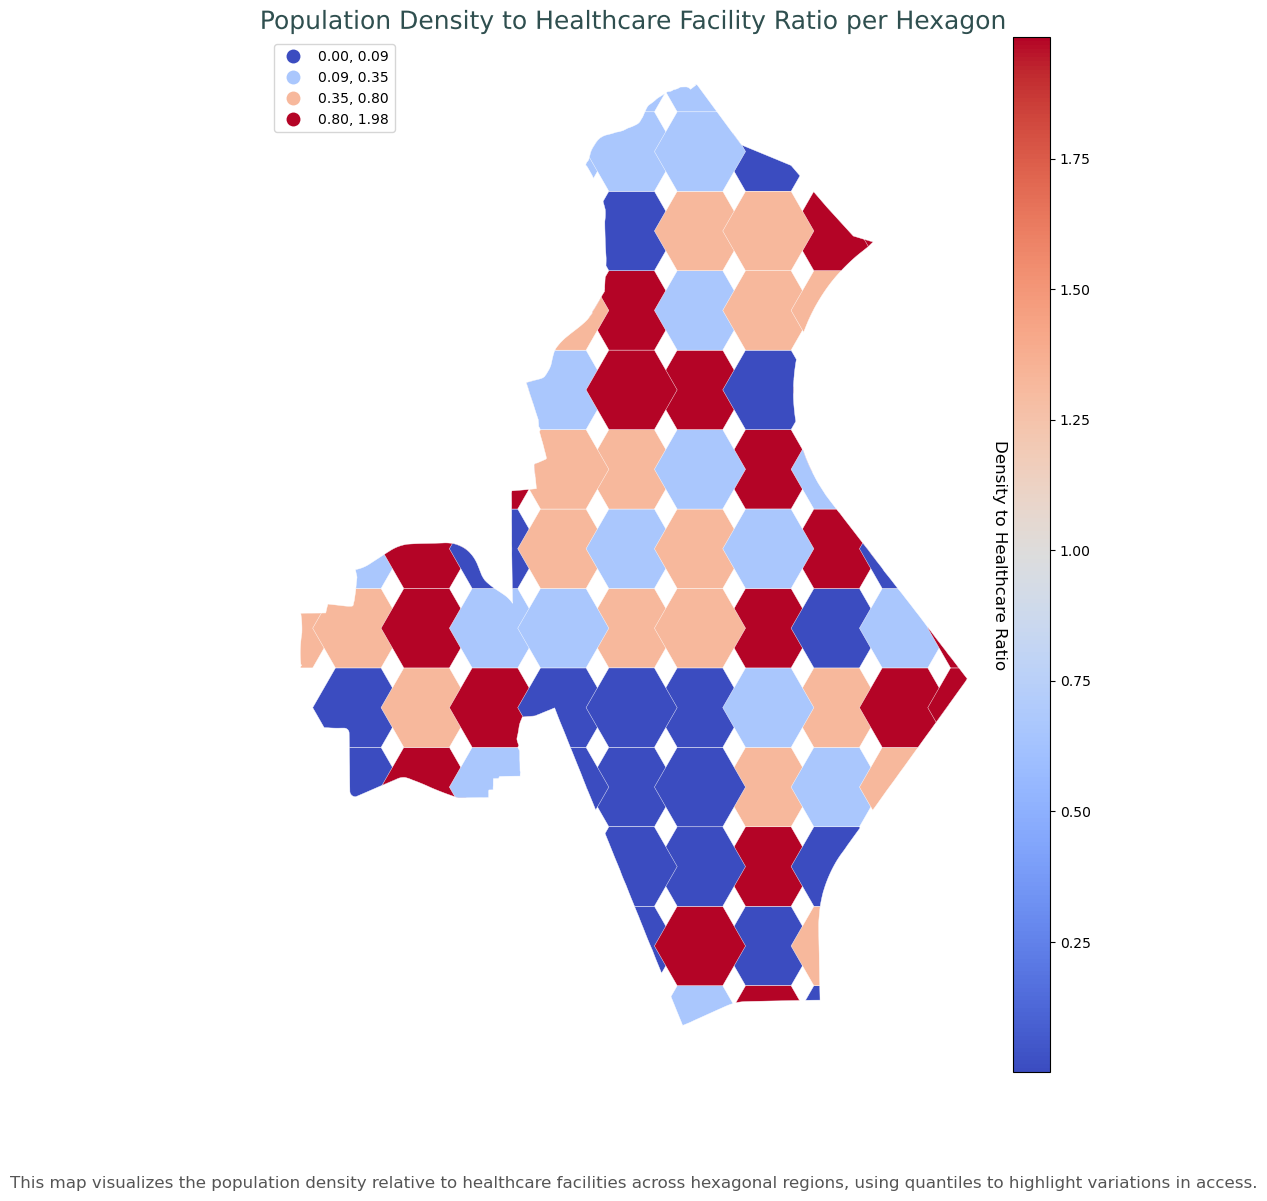

<Figure size 640x480 with 0 Axes>

In [69]:
import matplotlib.pyplot as plt
import matplotlib.patheffects as PathEffects
from mpl_toolkits.axes_grid1 import make_axes_locatable
import geopandas as gpd

# Plot the data
fig, ax = plt.subplots(figsize=(12, 12))
divider = make_axes_locatable(ax)

# Plot hex grid with color scheme and classes
hex_plot = hex_grid.plot(
    column="density_to_healthcare_ratio",
    cmap="coolwarm",
    scheme="Quantiles",
    k=4,
    legend=True,
    edgecolor="white",
    linewidth=0.3,
    ax=ax
)

# Customize background color and remove x/y axis
ax.set_facecolor("#f2f2f2")  # Soft grey background
ax.set_axis_off()

# Title with shadow effect for emphasis
title_text = plt.title("Population Density to Healthcare Facility Ratio per Hexagon", fontsize=18, color="#2f4f4f")
title_text.set_path_effects([PathEffects.withStroke(linewidth=2, foreground="white")])

# Add annotations
description = ("This map visualizes the population density relative to healthcare "
               "facilities across hexagonal regions, using quantiles to highlight "
               "variations in access.")
ax.text(0.5, -0.1, description, ha="center", va="top", transform=ax.transAxes, fontsize=12, color="#555555")

# Legend adjustments
cax = divider.append_axes("right", size="5%", pad=0.1)
sm = plt.cm.ScalarMappable(cmap="coolwarm", norm=plt.Normalize(vmin=hex_grid["density_to_healthcare_ratio"].min(),
                                                               vmax=hex_grid["density_to_healthcare_ratio"].max()))
cbar = fig.colorbar(sm, cax=cax)
cbar.set_label("Density to Healthcare Ratio", rotation=270, labelpad=15, fontsize=12)
cbar.ax.yaxis.set_label_position('left')




# Adding North Arrow
ax.text(0.95, 0.95, 'N', transform=ax.transAxes, fontsize=18, color="white", ha='center')
north_arrow = mpatches.FancyArrow(0.95, 0.88, 0, 0.05, transform=ax.transAxes, color="white", width=0.02)
ax.add_patch(north_arrow)

# Export the visualization as a high-resolution image
plt.tight_layout()
plt.savefig("population_density_healthcare_ratio_reall_map.png", dpi=300, bbox_inches='tight', facecolor=fig.get_facecolor())

# Show the plot
plt.show()
# Optional: Add scale bar and compass if desired

plt.tight_layout()
plt.show()


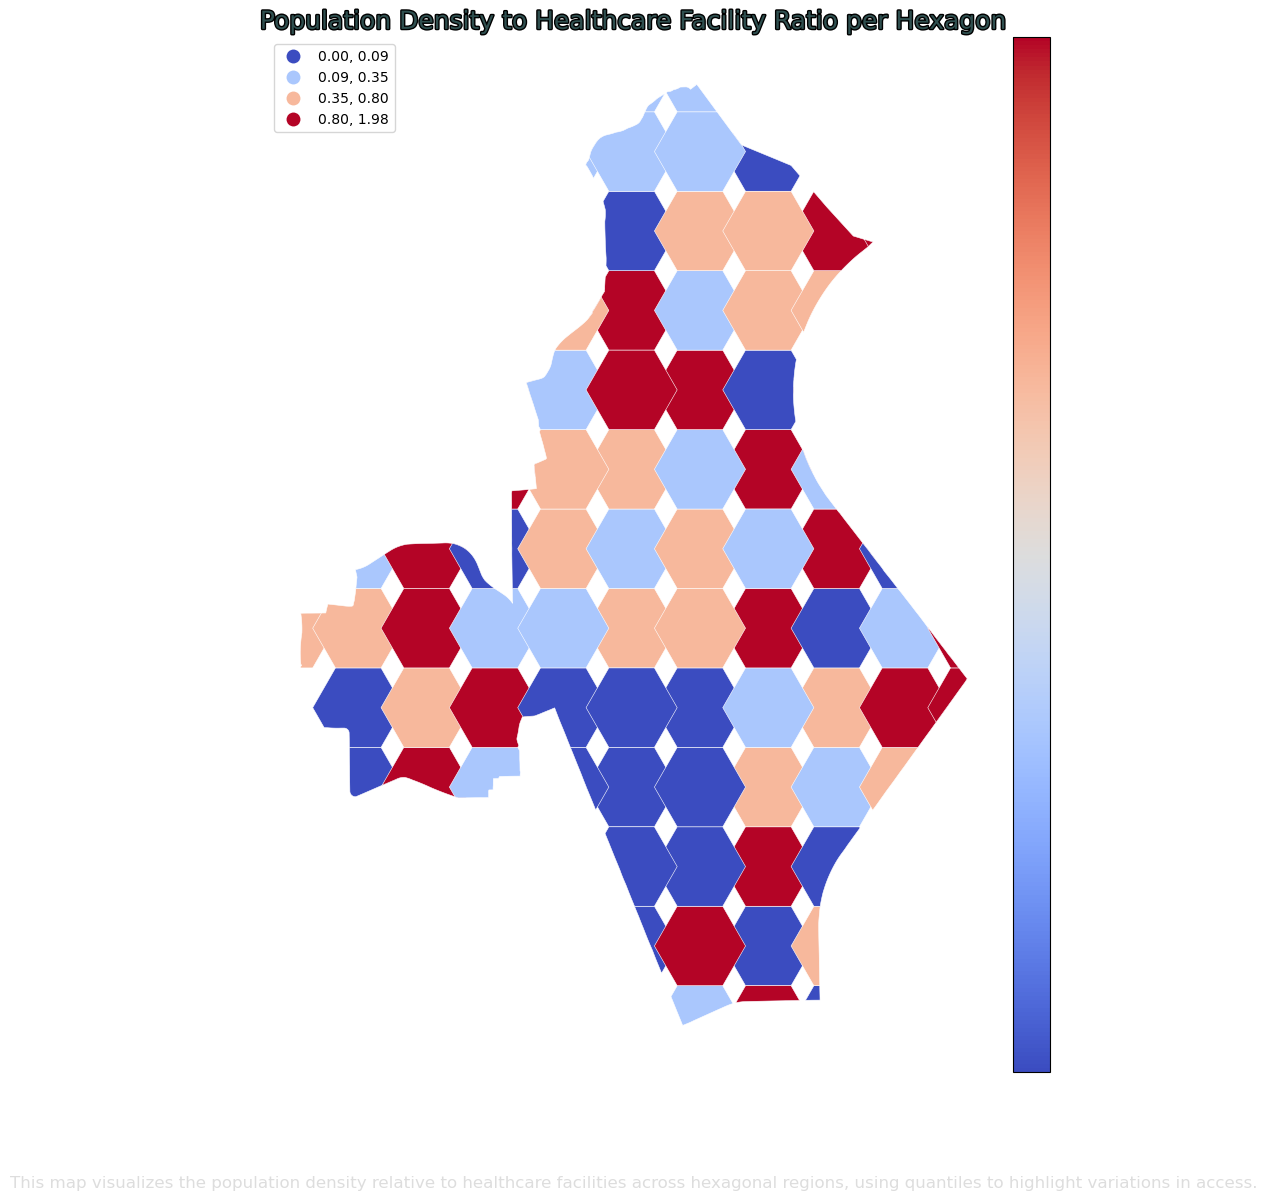

In [63]:
import matplotlib.pyplot as plt
import matplotlib.patheffects as PathEffects
from mpl_toolkits.axes_grid1 import make_axes_locatable
import geopandas as gpd
import matplotlib.patches as mpatches

# Plot the data
fig, ax = plt.subplots(figsize=(12, 12))
divider = make_axes_locatable(ax)

# Darker background color
ax.set_facecolor("#2f2f2f")  # Dark charcoal background

# Plot hex grid with color scheme and classes
hex_plot = hex_grid.plot(
    column="density_to_healthcare_ratio",
    cmap="coolwarm",
    scheme="Quantiles",
    k=4,
    legend=True,
    edgecolor="white",
    linewidth=0.4,
    ax=ax
)

# Remove x/y axis
ax.set_axis_off()

# Title with shadow effect for emphasis
title_text = plt.title("Population Density to Healthcare Facility Ratio per Hexagon", fontsize=18, color="#2f4f4f")
title_text.set_path_effects([PathEffects.withStroke(linewidth=2, foreground="#000000")])

# Add annotations
description = ("This map visualizes the population density relative to healthcare "
               "facilities across hexagonal regions, using quantiles to highlight "
               "variations in access.")
ax.text(0.5, -0.1, description, ha="center", va="top", transform=ax.transAxes, fontsize=12, color="#dddddd")

# Adjust legend
cax = divider.append_axes("right", size="5%", pad=0.1)
sm = plt.cm.ScalarMappable(cmap="coolwarm", norm=plt.Normalize(vmin=hex_grid["density_to_healthcare_ratio"].min(),
                                                               vmax=hex_grid["density_to_healthcare_ratio"].max()))
cbar = fig.colorbar(sm, cax=cax)
cbar.set_label("Density to Healthcare Ratio", rotation=270, labelpad=15, fontsize=12, color="#ffffff")
cbar.ax.yaxis.set_label_position('left')
cbar.ax.tick_params(color="white", labelcolor="white")

# Adding North Arrow
ax.text(0.95, 0.95, 'N', transform=ax.transAxes, fontsize=18, color="white", ha='center')
north_arrow = mpatches.FancyArrow(0.95, 0.88, 0, 0.05, transform=ax.transAxes, color="white", width=0.02)
ax.add_patch(north_arrow)

# Export the visualization as a high-resolution image
plt.tight_layout()
plt.savefig("population_density_healthcare_ratio_map.png", dpi=300, bbox_inches='tight', facecolor=fig.get_facecolor())

# Show the plot
plt.show()


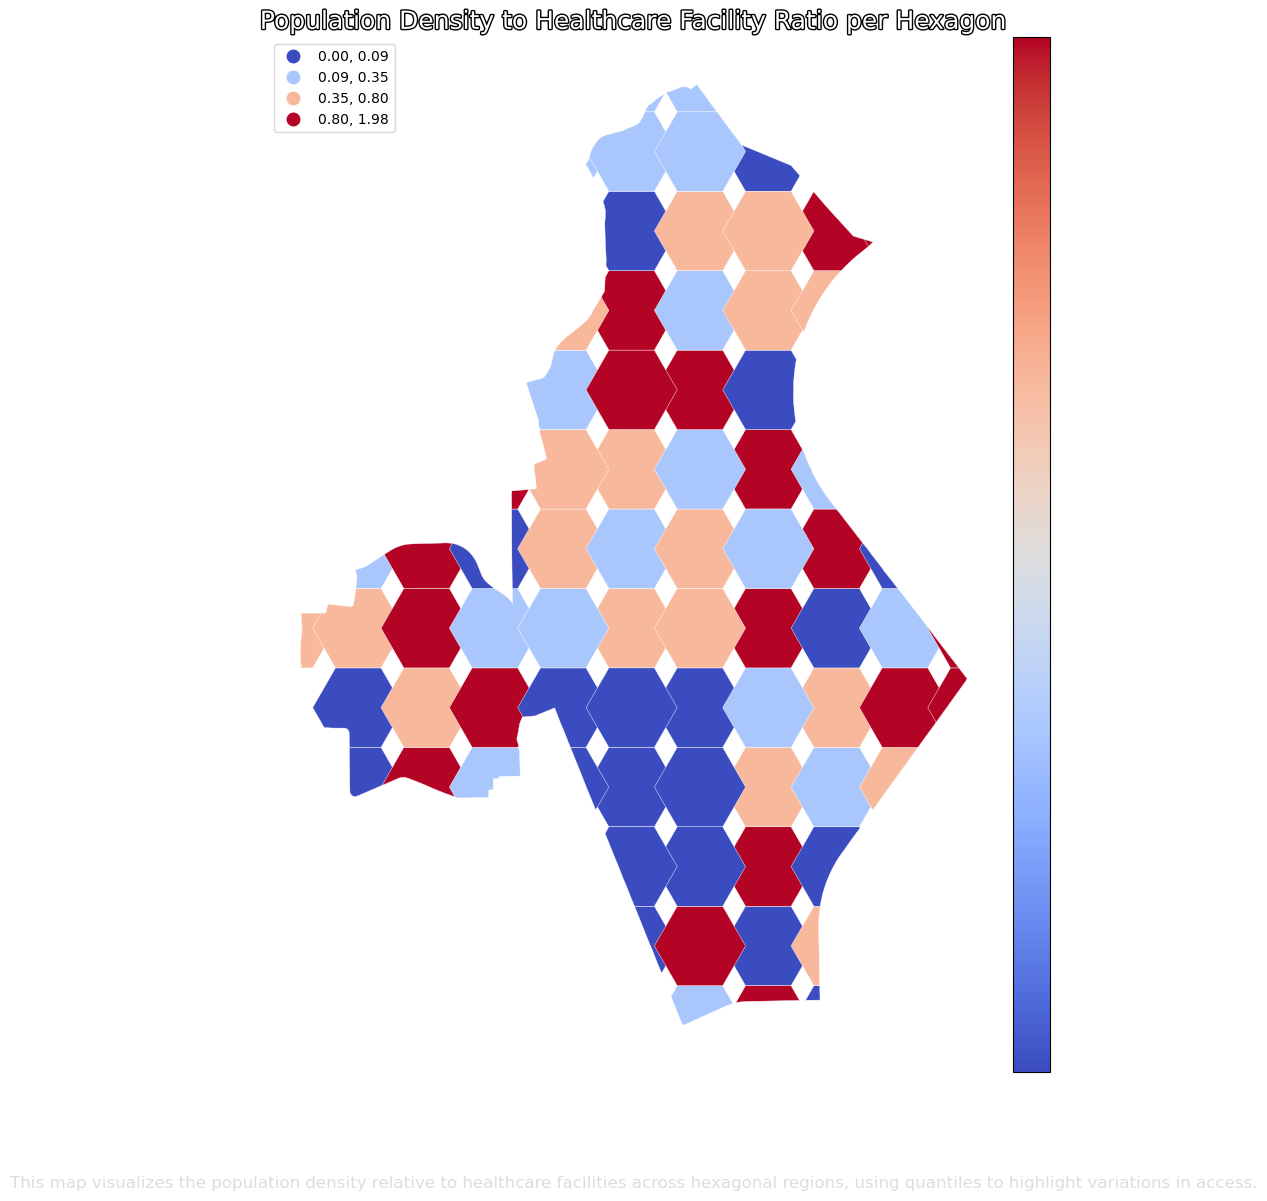

In [66]:
import matplotlib.pyplot as plt
import matplotlib.patheffects as PathEffects
from mpl_toolkits.axes_grid1 import make_axes_locatable
import geopandas as gpd
import matplotlib.patches as mpatches

# Plot the data
fig, ax = plt.subplots(figsize=(12, 12))
divider = make_axes_locatable(ax)

# Plot hex grid with color scheme and classes
hex_plot = hex_grid.plot(
    column="density_to_healthcare_ratio",
    cmap="coolwarm",
    scheme="Quantiles",
    k=4,
    legend=True,
    edgecolor="white",
    linewidth=0.3,
    ax=ax
)

# Customize background color and remove x/y axis
ax.set_facecolor("#333333")  # Darker background
ax.set_axis_off()

# Title with shadow effect for emphasis
title_text = plt.title("Population Density to Healthcare Facility Ratio per Hexagon", fontsize=18, color="#ffffff")
title_text.set_path_effects([PathEffects.withStroke(linewidth=2, foreground="black")])

# Add annotations
description = ("This map visualizes the population density relative to healthcare "
               "facilities across hexagonal regions, using quantiles to highlight "
               "variations in access.")
ax.text(0.5, -0.1, description, ha="center", va="top", transform=ax.transAxes, fontsize=12, color="#dddddd")

# Legend adjustments
cax = divider.append_axes("right", size="5%", pad=0.1)
sm = plt.cm.ScalarMappable(cmap="coolwarm", norm=plt.Normalize(vmin=hex_grid["density_to_healthcare_ratio"].min(),
                                                               vmax=hex_grid["density_to_healthcare_ratio"].max()))
cbar = fig.colorbar(sm, cax=cax)
cbar.set_label("Density to Healthcare Ratio", rotation=270, labelpad=15, fontsize=12, color="#ffffff")
cbar.ax.yaxis.set_label_position('left')
cbar.ax.tick_params(color="white", labelcolor="white")

# Adding North Arrow
ax.text(0.95, 0.95, 'N', transform=ax.transAxes, fontsize=18, color="white", ha='center')
north_arrow = mpatches.FancyArrow(0.95, 0.88, 0, 0.05, transform=ax.transAxes, color="white", width=0.02)
ax.add_patch(north_arrow)

# Export the visualization as a high-resolution image
plt.tight_layout()
plt.savefig("population_density_healthcare_ration_map.png", dpi=300, bbox_inches='tight', facecolor=fig.get_facecolor())

# Show the plot
plt.show()
